In [67]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import normaltest 
import mplfinance as mpf
from arch import arch_model
import numpy as np
import yfinance as yf

sns.set_style("whitegrid")  
plt.rcParams["figure.figsize"] = (10, 6)

In [4]:
ticker = "NFLX"
company = yf.Ticker(ticker)

In [5]:
yesterday = datetime.now() - timedelta(days=1)
start_date = yesterday - timedelta(days = 1095)
yesterday = yesterday.strftime("%Y-%m-%d")
start_date = start_date.strftime("%Y-%m-%d")

In [48]:
data = yf.download(ticker, start = start_date, end = yesterday)


*********************100%***********************]  1 of 1 completed

In [49]:
data = data.reset_index()
data.columns = data.columns.get_level_values(0)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0) 
data['Date'] = pd.to_datetime(data['Date'])

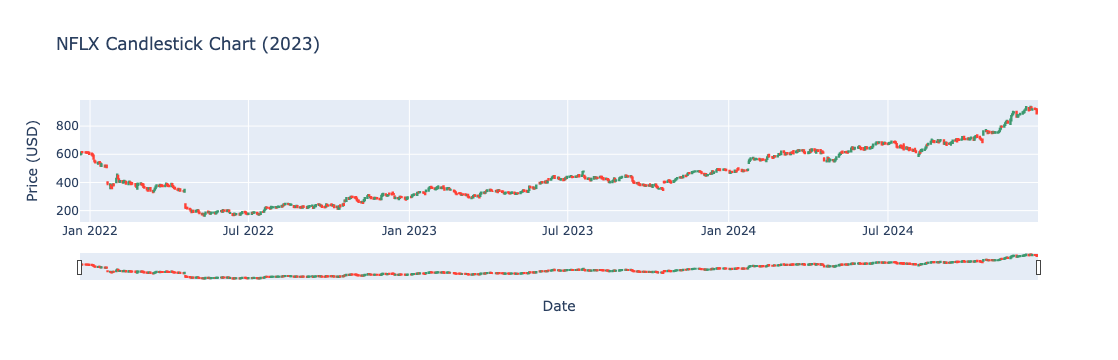

In [52]:
fig = go.Figure(data=[go.Candlestick(
    x=data['Date'],  
    open=data['Open'],  
    high=data['High'],  
    low=data['Low'],    
    close=data['Close']  
)])

fig.update_layout(
    title=f"{ticker} Candlestick Chart (2023)",
    xaxis_title="Date",
    yaxis_title="Price (USD)",
    xaxis_rangeslider_visible=True,  
)
fig.show()


In [62]:
close_data = data['Close']
open_data = data['Open']

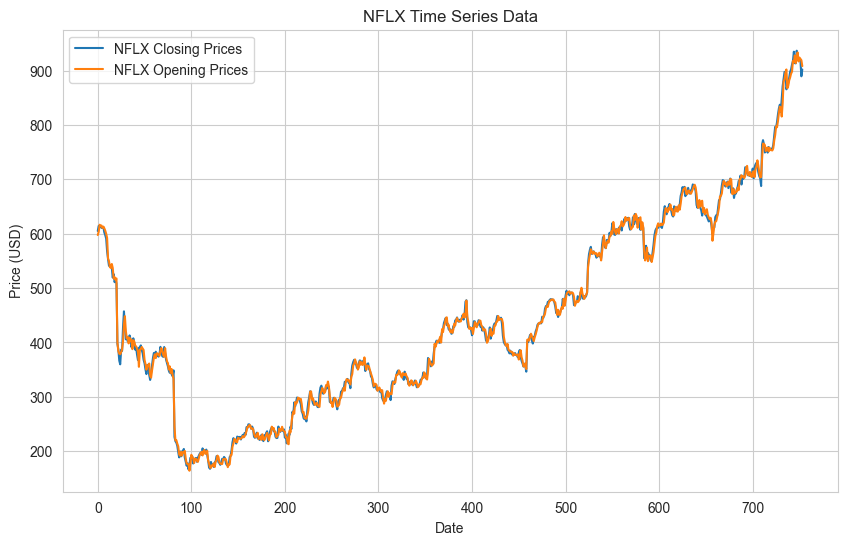

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(close_data, label=f'{ticker} Closing Prices')
plt.plot(open_data, label=f'{ticker} Opening Prices')
plt.title(f"{ticker} Time Series Data")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

In [57]:
adf_result = adfuller(close_data)

In [60]:
print("=== Augmented Dickey-Fuller Test Results ===")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.4f}")

# Interpretation
if adf_result[1] < 0.05:
    print("\nThe time series is stationary (reject the null hypothesis).")
else:
    print("\nThe time series is not stationary (fail to reject the null hypothesis).")


=== Augmented Dickey-Fuller Test Results ===
ADF Statistic: 0.6239
p-value: 0.9882
Critical Values:
   1%: -3.4391
   5%: -2.8654
   10%: -2.5688

The time series is not stationary (fail to reject the null hypothesis).


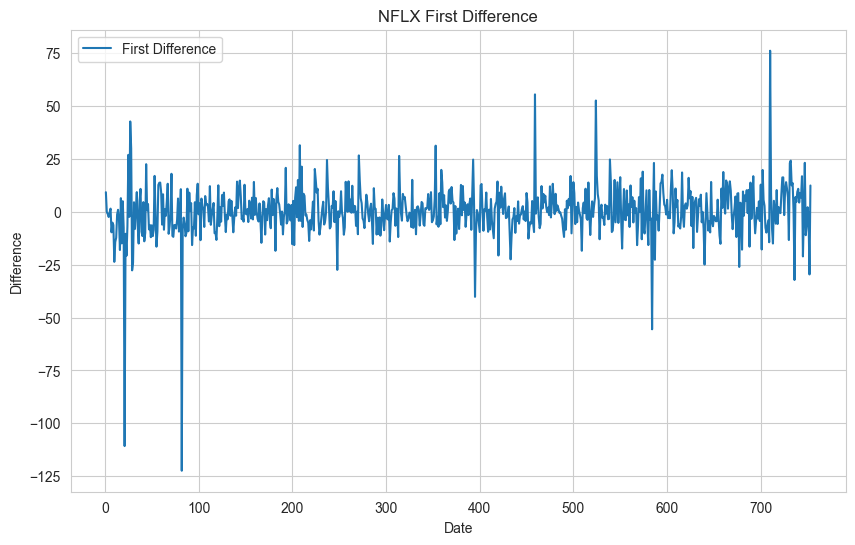

In [65]:
# 1. Differencing
first_diff = close_data.diff().dropna()
plt.figure(figsize=(10, 6))
plt.plot(first_diff, label='First Difference')
plt.title(f"{ticker} First Difference")
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.show()

In [73]:
adf_first_diff = adfuller(first_diff)
print("=== Augmented Dickey-Fuller Test Results ===")
print(f"ADF Statistic: {adf_first_diff[0]:.4f}")
print(f"p-value: {adf_first_diff[1]:.4f}")
print("Critical Values:")
for key, value in adf_first_diff[4].items():
    print(f"   {key}: {value:.4f}")

# Interpretation
if adf_first_diff[1] < 0.05:
    print("\nThe time series is stationary (reject the null hypothesis).")
else:
    print("\nThe time series is not stationary (fail to reject the null hypothesis).")


=== Augmented Dickey-Fuller Test Results ===
ADF Statistic: -26.2233
p-value: 0.0000
Critical Values:
   1%: -3.4391
   5%: -2.8654
   10%: -2.5688

The time series is stationary (reject the null hypothesis).


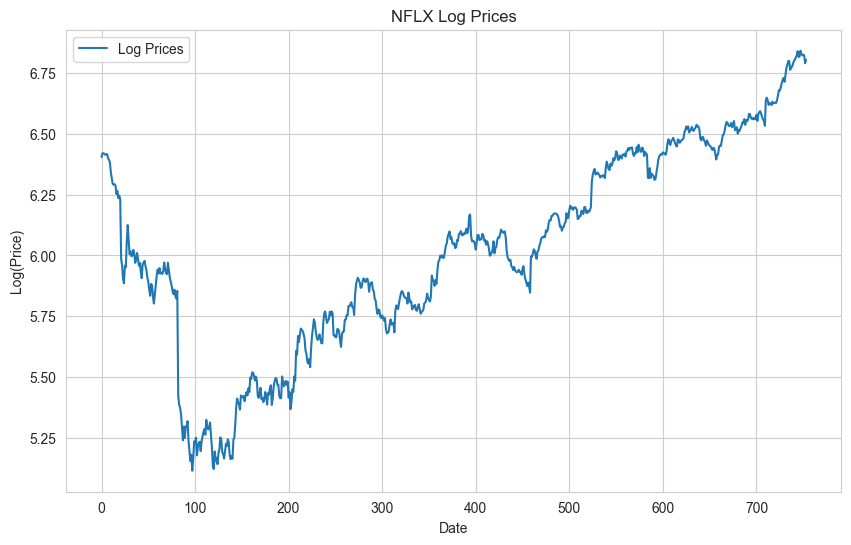

In [68]:
# 2. Log Transform
log_prices = np.log(close_data)
plt.figure(figsize=(10, 6))
plt.plot(log_prices, label='Log Prices')
plt.title(f"{ticker} Log Prices")
plt.xlabel('Date')
plt.ylabel('Log(Price)')
plt.legend()
plt.show()

In [74]:
adf_log_prices = adfuller(log_prices)
print("=== Augmented Dickey-Fuller Test Results ===")
print(f"ADF Statistic: {adf_log_prices[0]:.4f}")
print(f"p-value: {adf_log_prices[1]:.4f}")
print("Critical Values:")
for key, value in adf_log_prices[4].items():
    print(f"   {key}: {value:.4f}")

# Interpretation
if adf_log_prices[1] < 0.05:
    print("\nThe time series is stationary (reject the null hypothesis).")
else:
    print("\nThe time series is not stationary (fail to reject the null hypothesis).")

=== Augmented Dickey-Fuller Test Results ===
ADF Statistic: -0.4160
p-value: 0.9074
Critical Values:
   1%: -3.4391
   5%: -2.8654
   10%: -2.5688

The time series is not stationary (fail to reject the null hypothesis).


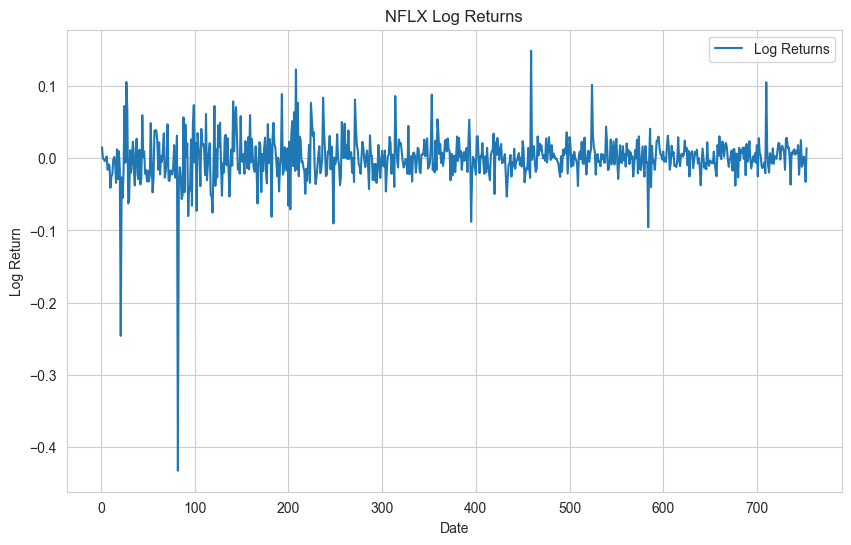

In [69]:
# 3. Log Returns
log_returns = log_prices.diff().dropna()
plt.figure(figsize=(10, 6))
plt.plot(log_returns, label='Log Returns')
plt.title(f"{ticker} Log Returns")
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.show()

In [75]:
adf_log_returns = adfuller(log_returns)
print("=== Augmented Dickey-Fuller Test Results ===")
print(f"ADF Statistic: {adf_log_returns[0]:.4f}")
print(f"p-value: {adf_log_returns[1]:.4f}")
print("Critical Values:")
for key, value in adf_log_returns[4].items():
    print(f"   {key}: {value:.4f}")

# Interpretation
if adf_log_returns[1] < 0.05:
    print("\nThe time series is stationary (reject the null hypothesis).")
else:
    print("\nThe time series is not stationary (fail to reject the null hypothesis).")

=== Augmented Dickey-Fuller Test Results ===
ADF Statistic: -26.7324
p-value: 0.0000
Critical Values:
   1%: -3.4391
   5%: -2.8654
   10%: -2.5688

The time series is stationary (reject the null hypothesis).


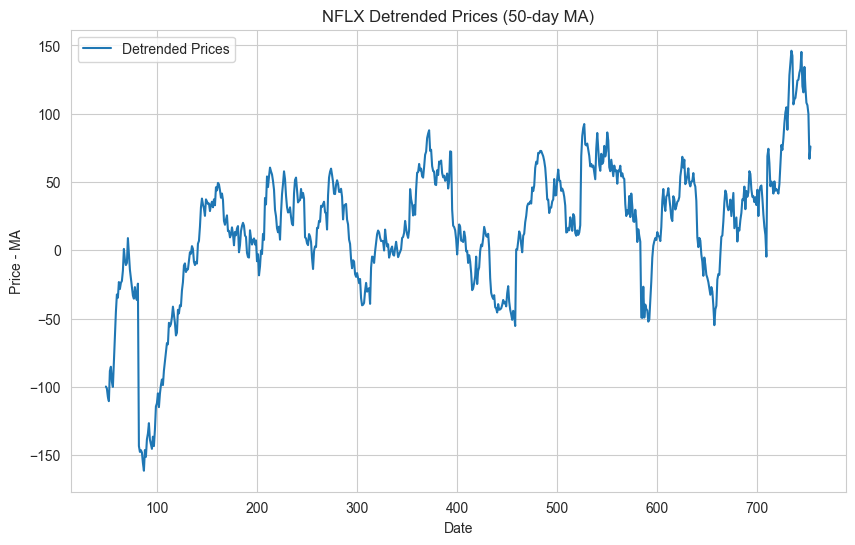

In [80]:
# 4. Detrending (Subtracting Moving Average)
moving_avg = close_data.rolling(window=50).mean()  # 50-day moving average
detrended = (close_data - moving_avg).dropna()
plt.figure(figsize=(10, 6))
plt.plot(detrended, label='Detrended Prices')
plt.title(f"{ticker} Detrended Prices (50-day MA)")
plt.xlabel('Date')
plt.ylabel('Price - MA')
plt.legend()
plt.show()

In [81]:
adf_detrended = adfuller(detrended)
print("=== Augmented Dickey-Fuller Test Results ===")
print(f"ADF Statistic: {adf_detrended[0]:.4f}")
print(f"p-value: {adf_detrended[1]:.4f}")
print("Critical Values:")
for key, value in adf_detrended[4].items():
    print(f"   {key}: {value:.4f}")

# Interpretation
if adf_detrended[1] < 0.05:
    print("\nThe time series is stationary (reject the null hypothesis).")
else:
    print("\nThe time series is not stationary (fail to reject the null hypothesis).")

=== Augmented Dickey-Fuller Test Results ===
ADF Statistic: -3.3188
p-value: 0.0141
Critical Values:
   1%: -3.4397
   5%: -2.8657
   10%: -2.5690

The time series is stationary (reject the null hypothesis).


In [ ]:
# 1 differencing and # 3 log returns and # 4 detrended (moving average difference) 

In [90]:
# After achieving stationarity, you have multiple paths forward:

# Analyze relationships: Explore autocorrelation, seasonality, or causal relationships. (Use autocorelation to justify which model)
# Model the data: Build predictive models using ARIMA, GARCH, etc.
# Validate and improve: Perform residual diagnostics to ensure model quality.
# Extend to multivariate analysis: Use cross-correlation or causality tests for systems involving multiple series.
data.info()
first_diff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       754 non-null    datetime64[ns]
 1   Adj Close  754 non-null    float64       
 2   Close      754 non-null    float64       
 3   High       754 non-null    float64       
 4   Low        754 non-null    float64       
 5   Open       754 non-null    float64       
 6   Volume     754 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 41.4 KB
<class 'pandas.core.series.Series'>
Index: 753 entries, 1 to 753
Series name: Close
Non-Null Count  Dtype  
--------------  -----  
753 non-null    float64
dtypes: float64(1)
memory usage: 11.8 KB


In [82]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

<Figure size 1000x600 with 0 Axes>

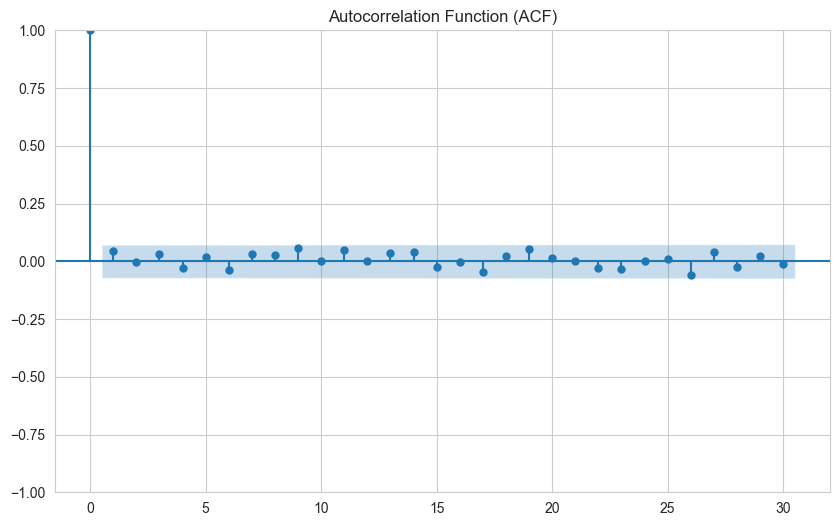

<Figure size 1000x600 with 0 Axes>

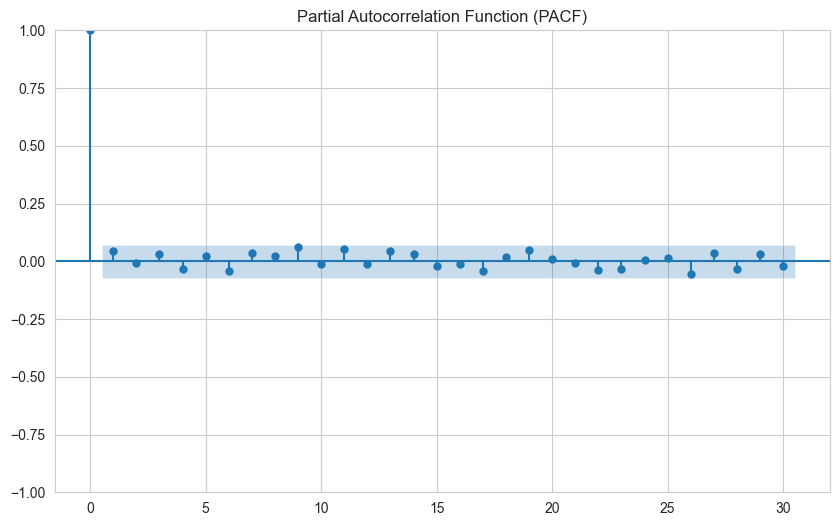

In [96]:
#first_diff
#Plot ACF
plt.figure(figsize=(10, 6))
plot_acf(first_diff, lags=30, title="Autocorrelation Function (ACF)")
plt.show()

# Plot PACF
plt.figure(figsize=(10, 6))
plot_pacf(first_diff, lags=30, title="Partial Autocorrelation Function (PACF)")
plt.show()

<Figure size 1000x600 with 0 Axes>

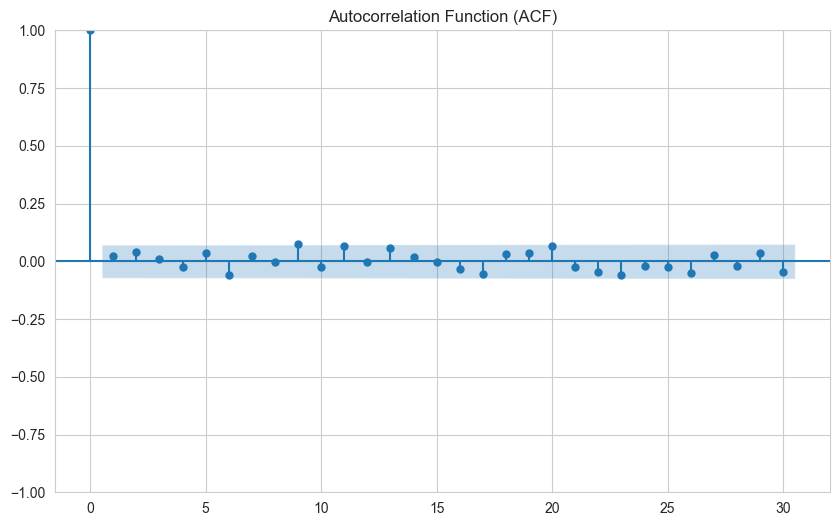

<Figure size 1000x600 with 0 Axes>

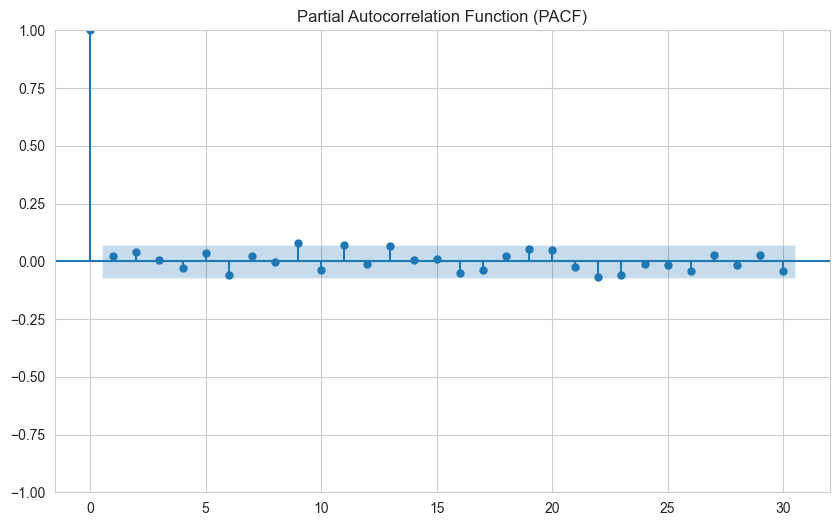

In [84]:
#log_returns
#Plot ACF
plt.figure(figsize=(10, 6))
plot_acf(log_returns, lags=30, title="Autocorrelation Function (ACF)")
plt.show()

# Plot PACF
plt.figure(figsize=(10, 6))
plot_pacf(log_returns, lags=30, title="Partial Autocorrelation Function (PACF)")
plt.show()

<Figure size 1000x600 with 0 Axes>

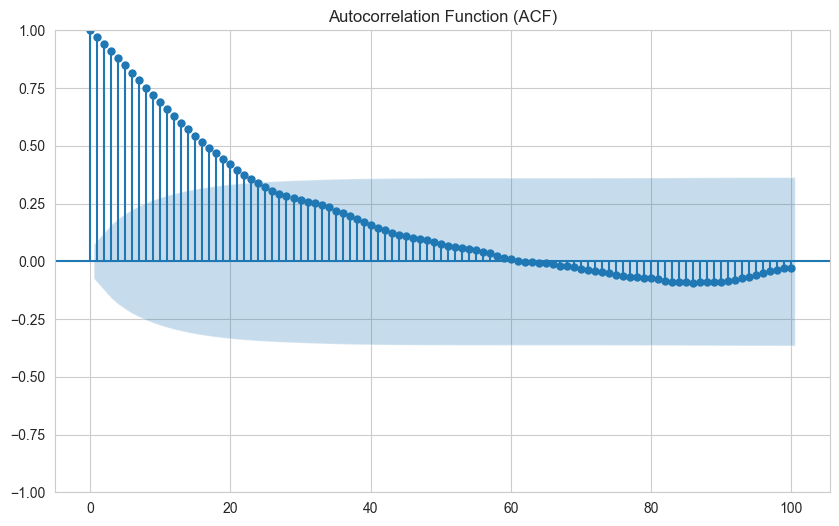

<Figure size 1000x600 with 0 Axes>

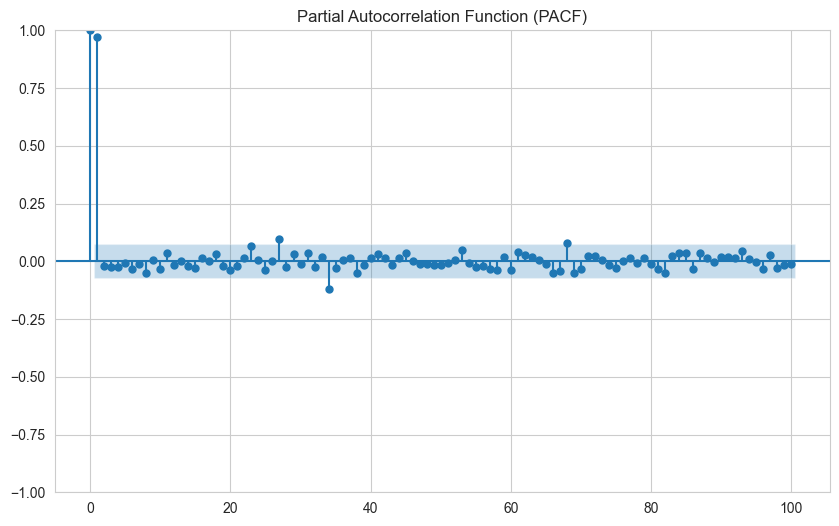

In [97]:
#detrended
#Plot ACF
plt.figure(figsize=(10, 6))
plot_acf(detrended, lags=100, title="Autocorrelation Function (ACF)")
plt.show()

# Plot PACF
plt.figure(figsize=(10, 6))
plot_pacf(detrended, lags=100, title="Partial Autocorrelation Function (PACF)")
plt.show()

In [ ]:
#Check for over differencing - this is kind of checked within the process of the time series analysis (through ACF and PACF, Residual analysis after model fitting, 

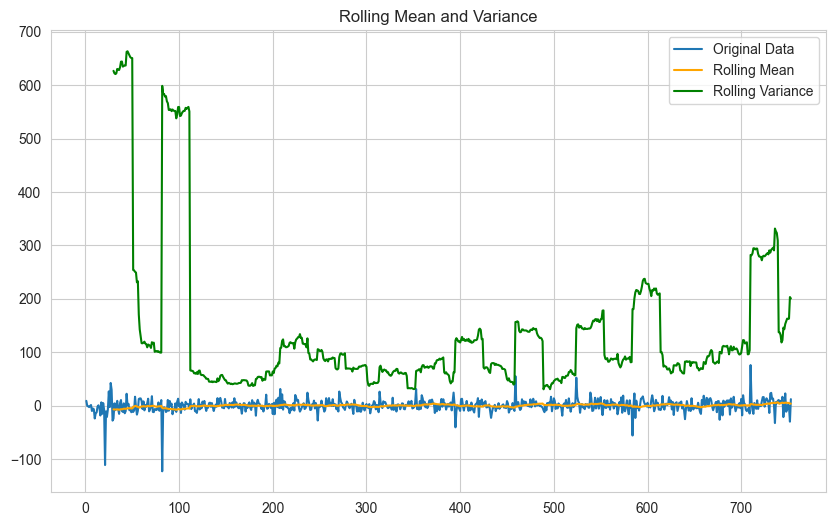

In [98]:
#Checking for white noise in the different types of stationary(coverted) data
# Calculate rolling statistics
rolling_mean_fd = first_diff.rolling(window=30).mean()
rolling_variance_fd = first_diff.rolling(window=30).var()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(first_diff, label='Original Data')
plt.plot(rolling_mean_fd, label='Rolling Mean', color='orange')
plt.plot(rolling_variance_fd, label='Rolling Variance', color='green')
plt.legend()
plt.title('Rolling Mean and Variance')
plt.show()

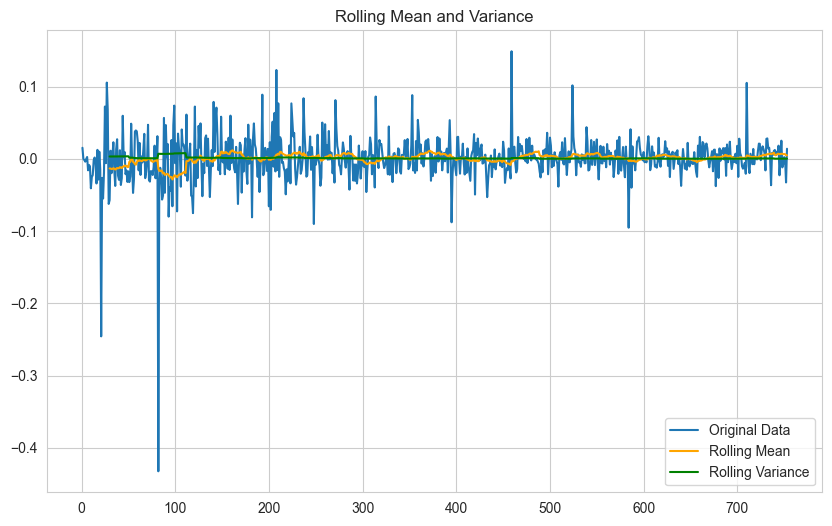

In [99]:
#log returns checking variance and mean consistency
rolling_mean_lr = log_returns.rolling(window=30).mean()
rolling_variance_lr = log_returns.rolling(window=30).var()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(log_returns, label='Original Data')
plt.plot(rolling_mean_lr, label='Rolling Mean', color='orange')
plt.plot(rolling_variance_lr, label='Rolling Variance', color='green')
plt.legend()
plt.title('Rolling Mean and Variance')
plt.show()

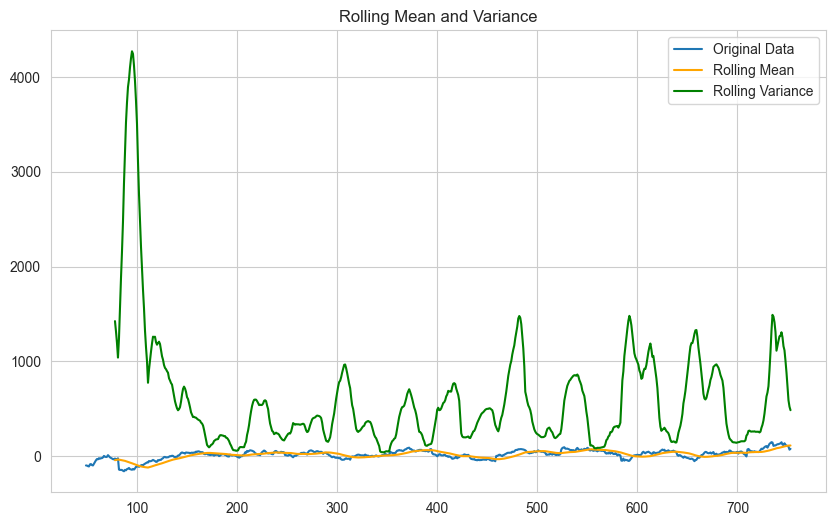

In [100]:
#detrended
rolling_mean_d = detrended.rolling(window=30).mean()
rolling_variance_d = detrended.rolling(window=30).var()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(detrended, label='Original Data')
plt.plot(rolling_mean_d, label='Rolling Mean', color='orange')
plt.plot(rolling_variance_d, label='Rolling Variance', color='green')
plt.legend()
plt.title('Rolling Mean and Variance')
plt.show()

In [101]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Perform Ljung-Box test on first difference
ljung_box_result_fd = acorr_ljungbox(first_diff, lags=30, return_df=True)
print(ljung_box_result_fd)

#

      lb_stat  lb_pvalue
1    1.397668   0.237114
2    1.407720   0.494672
3    2.129874   0.545893
4    2.769130   0.597173
5    3.080166   0.687628
6    4.169874   0.653700
7    4.832761   0.680364
8    5.485940   0.704597
9    8.174652   0.516646
10   8.174944   0.611753
11  10.039040   0.526879
12  10.039555   0.612490
13  11.108911   0.601694
14  12.308779   0.581520
15  12.744333   0.622038
16  12.763030   0.689999
17  14.409253   0.637950
18  14.768194   0.677818
19  16.970887   0.591840
20  17.135520   0.644157
21  17.141757   0.702478
22  17.818077   0.716718
23  18.702036   0.718377
24  18.702591   0.767659
25  18.753141   0.808801
26  21.408821   0.720566
27  22.643758   0.703994
28  23.136701   0.726169
29  23.560220   0.750305
30  23.676940   0.786440


In [112]:
# Perform Ljung-Box test on log returns
ljung_box_result_lr = acorr_ljungbox(log_returns, lags=102, return_df=True)
print(ljung_box_result_lr)

        lb_stat  lb_pvalue
1      0.441811   0.506250
2      1.647026   0.438887
3      1.703521   0.636151
4      2.202632   0.698548
5      3.164623   0.674623
..          ...        ...
98   117.937150   0.083111
99   118.130860   0.092190
100  119.411529   0.090268
101  119.704221   0.098731
102  121.792071   0.088343

[102 rows x 2 columns]


In [113]:
# Perform Ljung-Box test on detrended
ljung_box_result_d = acorr_ljungbox(detrended, lags=2, return_df=True)
print(ljung_box_result_d)

# Passes the test

         lb_stat      lb_pvalue
1     666.386946  6.100155e-147
2    1292.919405  1.762456e-281
3    1880.074624   0.000000e+00
4    2428.589657   0.000000e+00
5    2940.445016   0.000000e+00
..           ...            ...
98   8397.614218   0.000000e+00
99   8398.410714   0.000000e+00
100  8399.009183   0.000000e+00
101  8399.454513   0.000000e+00
102  8399.791818   0.000000e+00

[102 rows x 2 columns]


In [ ]:
# According to the pacf and acf the detrended data set has enough statistical significance to use the ARIMA model on but ultimately we would
# have to use the GARCH model as it is most relevant to stock prices. 

In [ ]:
# According to the document labelled - ARIMA_Model_Terms_and_ACF_PACF_relationship, since for the detrended data set, the ACF gradually tapers
# off while the PACF cuts of at lag to our ordering should be, p = 1 (ACF tapers, PACF cuts off at lag 1) , q = 0 and d = 0. (Test with others) 
#Test with other degrees for p, q and d for this model, try GARCH , still need to analyse seasonality and trend. 

In [123]:
from statsmodels.tsa.arima.model import ARIMA
#printed with original data by mistake
# Original data (AR(1) model)
model_no_diff = ARIMA(close_data, order=(1, 0, 0))  # No differencing
model_no_diff_fit = model_no_diff.fit()
print("No Differencing AIC:", model_no_diff_fit.aic)
print(model_no_diff_fit.summary())

No Differencing AIC: 5898.708999356415
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  754
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2946.354
Date:                Thu, 09 Jan 2025   AIC                           5898.709
Time:                        14:45:07   BIC                           5912.585
Sample:                             0   HQIC                          5904.054
                                - 754                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        448.0615    408.198      1.098      0.272    -351.992    1248.115
ar.L1          0.9991      0.002    519.579      0.000       0.995       1.003
sigma2       

/Users/anilsaddatbijoy/.pyenv/versions/3.8.17/envs/stochasticEnv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



In [125]:
# Detrended (AR(1))
model_no_diff_ar1 = ARIMA(detrended, order=(1, 0, 0))  # No differencing
model_no_diff_fit_ar1 = model_no_diff_ar1.fit()
print("No Differencing AIC:", model_no_diff_fit_ar1.aic)
print(model_no_diff_fit_ar1.summary())

No Differencing AIC: 5380.855368149967
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  705
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2687.428
Date:                Thu, 09 Jan 2025   AIC                           5380.855
Time:                        14:46:34   BIC                           5394.530
Sample:                             0   HQIC                          5386.140
                                - 705                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.3289     16.582      0.744      0.457     -20.171      44.828
ar.L1          0.9783      0.007    131.006      0.000       0.964       0.993
sigma2       

/Users/anilsaddatbijoy/.pyenv/versions/3.8.17/envs/stochasticEnv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/anilsaddatbijoy/.pyenv/versions/3.8.17/envs/stochasticEnv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/anilsaddatbijoy/.pyenv/versions/3.8.17/envs/stochasticEnv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



In [126]:
# detrended AR(2)
model_no_diff_ar2 = ARIMA(detrended, order=(2, 0, 0))  # No differencing
model_no_diff_fit_ar2 = model_no_diff_ar2.fit()
print("No Differencing AIC:", model_no_diff_fit_ar2.aic)
print(model_no_diff_fit_ar2.summary())

No Differencing AIC: 5382.520024954946
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  705
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -2687.260
Date:                Thu, 09 Jan 2025   AIC                           5382.520
Time:                        14:47:33   BIC                           5400.753
Sample:                             0   HQIC                          5389.566
                                - 705                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.4439     16.516      0.935      0.350     -16.927      47.815
ar.L1          1.0005      0.046     21.958      0.000       0.911       1.090
ar.L2        

/Users/anilsaddatbijoy/.pyenv/versions/3.8.17/envs/stochasticEnv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/anilsaddatbijoy/.pyenv/versions/3.8.17/envs/stochasticEnv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/anilsaddatbijoy/.pyenv/versions/3.8.17/envs/stochasticEnv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



In [127]:
# detrended MA(1)
model_no_diff_ma1 = ARIMA(detrended, order=(0, 0, 1))  # No differencing
model_no_diff_fit_ma1 = model_no_diff_ma1.fit()
print("No Differencing AIC:", model_no_diff_fit_ma1.aic)
print(model_no_diff_fit_ma1.summary())

No Differencing AIC: 6717.081292259701
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  705
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -3355.541
Date:                Thu, 09 Jan 2025   AIC                           6717.081
Time:                        14:48:43   BIC                           6730.756
Sample:                             0   HQIC                          6722.366
                                - 705                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.4502      2.163      7.143      0.000      11.211      19.690
ma.L1          0.8863      0.013     69.496      0.000       0.861       0.911
sigma2       

/Users/anilsaddatbijoy/.pyenv/versions/3.8.17/envs/stochasticEnv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/anilsaddatbijoy/.pyenv/versions/3.8.17/envs/stochasticEnv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/anilsaddatbijoy/.pyenv/versions/3.8.17/envs/stochasticEnv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



In [128]:
# detrended AR(1) MA(1)
model_no_diff_ar1ma1 = ARIMA(detrended, order=(1, 0, 1))  # No differencing
model_no_diff_fit_ar1ma1 = model_no_diff_ar1ma1.fit()
print("No Differencing AIC:", model_no_diff_fit_ar1ma1.aic)
print(model_no_diff_fit_ar1ma1.summary())

/Users/anilsaddatbijoy/.pyenv/versions/3.8.17/envs/stochasticEnv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/anilsaddatbijoy/.pyenv/versions/3.8.17/envs/stochasticEnv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/anilsaddatbijoy/.pyenv/versions/3.8.17/envs/stochasticEnv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



No Differencing AIC: 5382.51400991843
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  705
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2687.257
Date:                Thu, 09 Jan 2025   AIC                           5382.514
Time:                        14:49:39   BIC                           5400.747
Sample:                             0   HQIC                          5389.560
                                - 705                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.4451     16.523      0.935      0.350     -16.940      47.830
ar.L1          0.9771      0.008    124.589      0.000       0.962       0.993
ma.L1         

In [122]:
# from statsmodels.stats.diagnostic import het_arch

# # ARCH test
# arch_test = het_arch(data)
# print("ARCH Test Statistic:", arch_test[0])
# print("p-value:", arch_test[1])

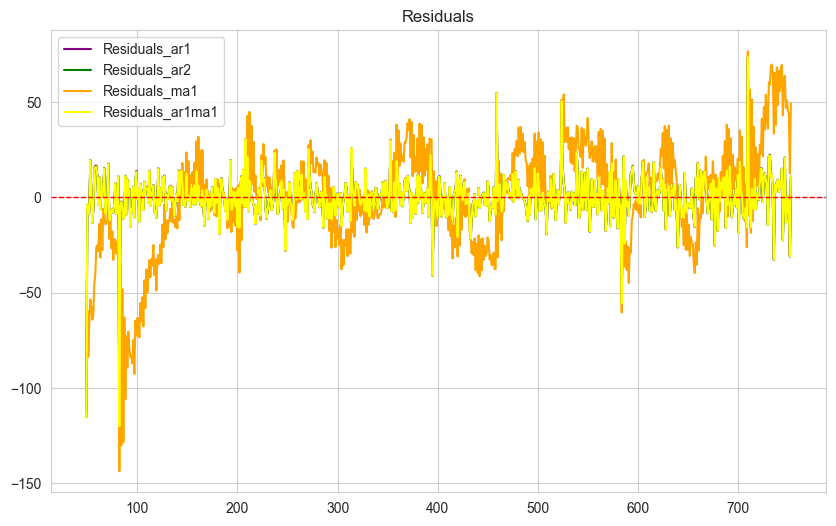

In [130]:
# Extract residuals
residuals_ar1 = model_no_diff_fit_ar1.resid
residuals_ar2 = model_no_diff_fit_ar2.resid
residuals_ma1 = model_no_diff_fit_ma1.resid
residuals_ar1ma1 = model_no_diff_fit_ar1ma1.resid

# Visualize residuals
plt.figure(figsize=(10, 6))
plt.plot(residuals_ar1, label='Residuals_ar1', color='purple')
plt.plot(residuals_ar2, label='Residuals_ar2', color='green')
plt.plot(residuals_ma1, label='Residuals_ma1', color='orange')
plt.plot(residuals_ar1ma1, label='Residuals_ar1ma1', color='yellow')

plt.axhline(0, linestyle='--', color='red', linewidth=1)
plt.title('Residuals')
plt.legend()
plt.show()

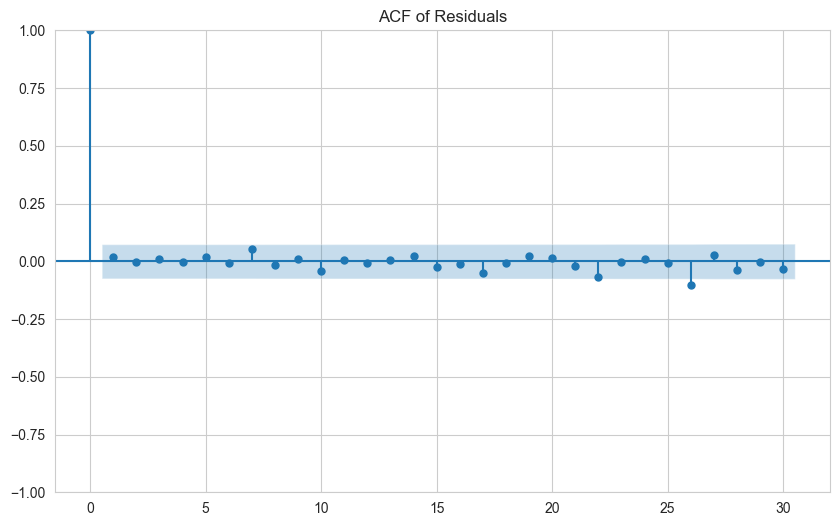

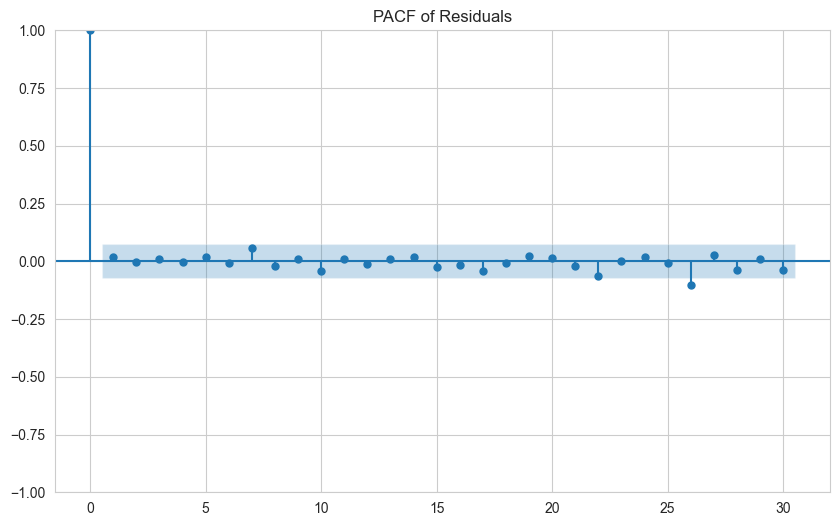

In [131]:
# ACF and PACF of residuals_ar1
plot_acf(residuals_ar1, lags=30, title="ACF of Residuals")
plt.show()

plot_pacf(residuals_ar1, lags=30, title="PACF of Residuals")
plt.show()

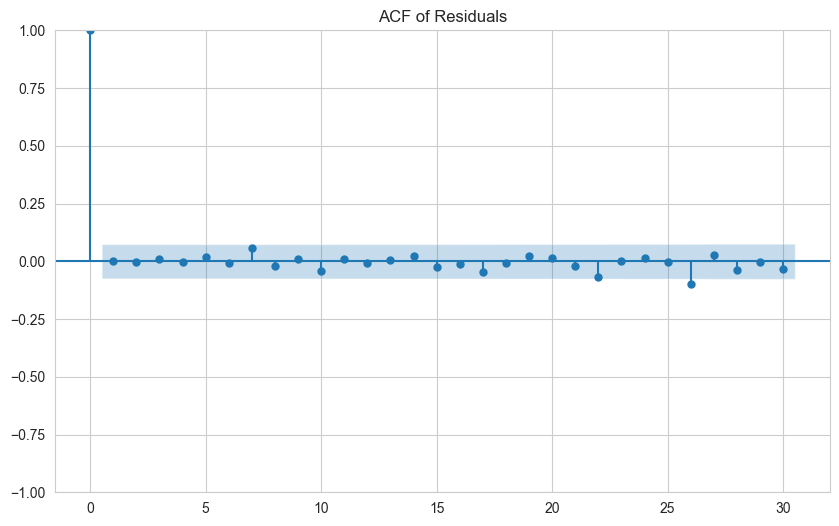

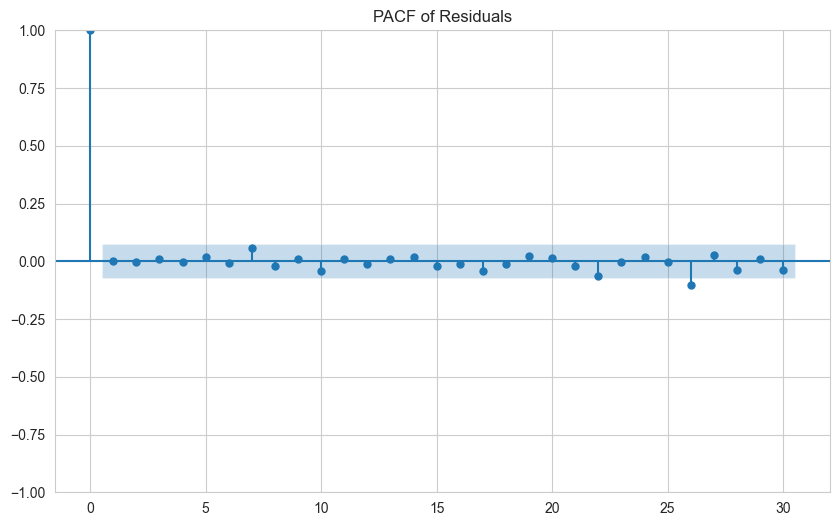

In [133]:
# ACF and PACF of residuals_ar2
plot_acf(residuals_ar2, lags=30, title="ACF of Residuals")
plt.show()

plot_pacf(residuals_ar2, lags=30, title="PACF of Residuals")
plt.show()

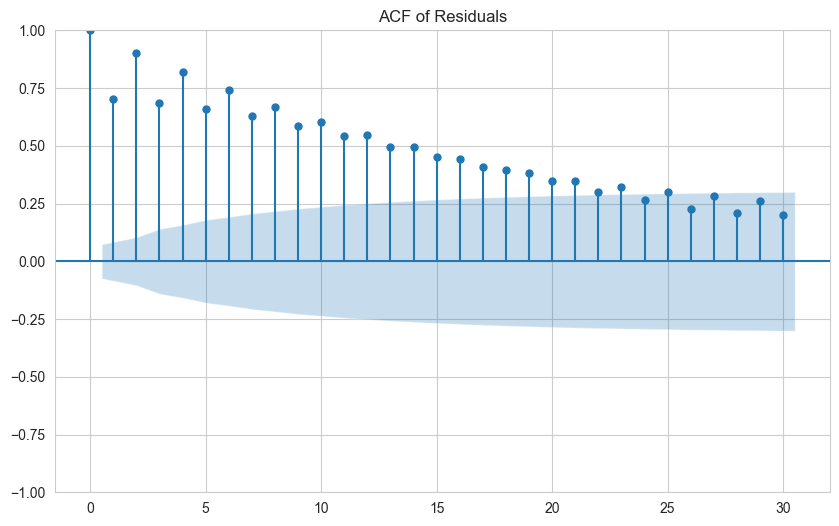

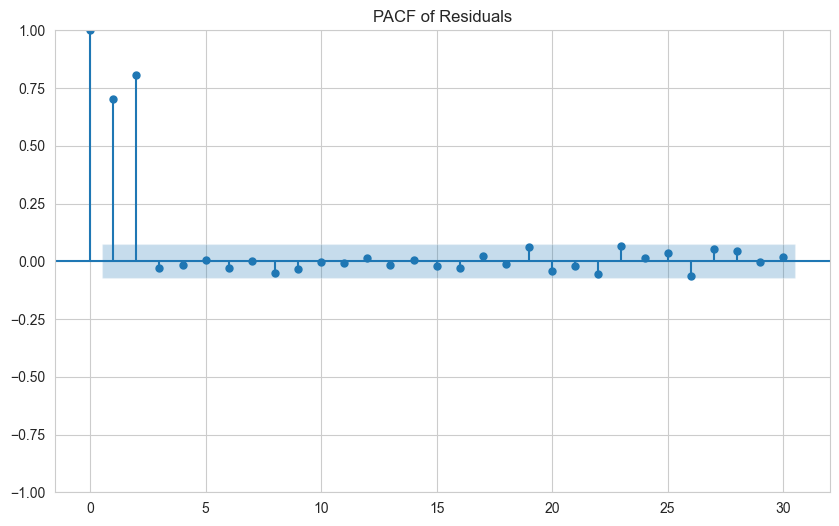

In [134]:
# ACF and PACF of residuals_ma1
plot_acf(residuals_ma1, lags=30, title="ACF of Residuals")
plt.show()

plot_pacf(residuals_ma1, lags=30, title="PACF of Residuals")
plt.show()

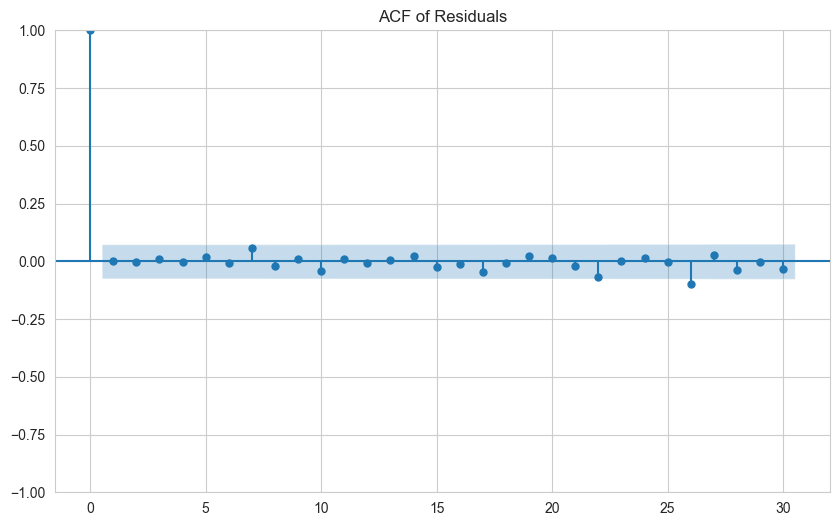

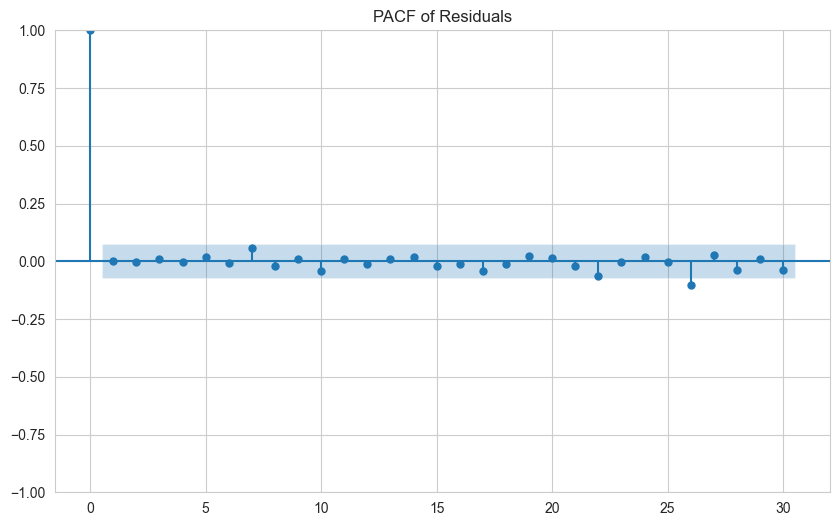

In [135]:
# ACF and PACF of residuals_ar1ma1
plot_acf(residuals_ar1ma1, lags=30, title="ACF of Residuals")
plt.show()

plot_pacf(residuals_ar1ma1, lags=30, title="PACF of Residuals")
plt.show()

In [139]:
# Ljung-Box test
ljung_box_result_ar1 = acorr_ljungbox(residuals_ar1, lags=[30], return_df=True)
print(ljung_box_result_ar1)

      lb_stat  lb_pvalue
30  21.547085   0.870005


In [138]:
ljung_box_result_ar2 = acorr_ljungbox(residuals_ar2, lags=[30], return_df=True)
print(ljung_box_result_ar2)

      lb_stat  lb_pvalue
30  21.203753   0.881409


In [137]:
ljung_box_result_ma1 = acorr_ljungbox(residuals_ma1, lags=[30], return_df=True)
print(ljung_box_result_ma1)

        lb_stat  lb_pvalue
30  5595.845799        0.0


In [136]:
ljung_box_result_ar1ma1 = acorr_ljungbox(residuals_ar1ma1, lags=[30], return_df=True)
print(ljung_box_result_ar1ma1)

      lb_stat  lb_pvalue
30  21.217723   0.880957


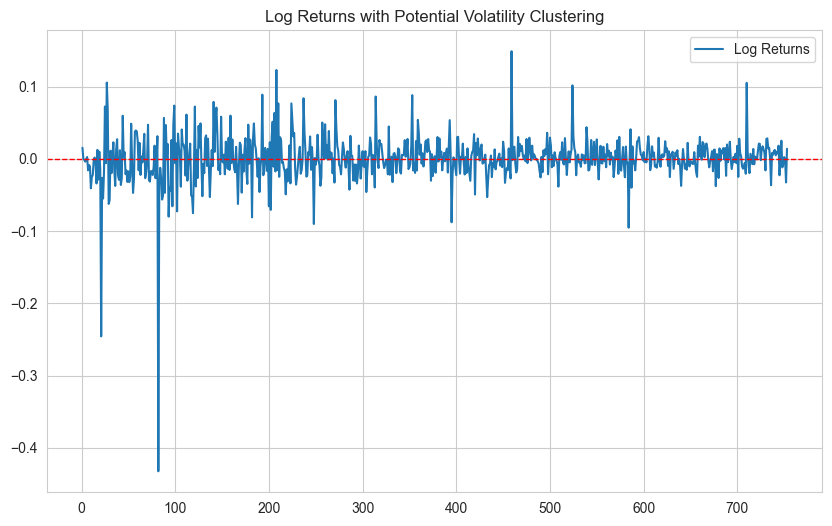

In [141]:
#Garch Process from here. 
#Checking for volatility clutering in 
# Visualize and confirm volatility clustering 

# Plot log returns 
plt.figure(figsize=(10, 6))
plt.plot(log_returns, label='Log Returns')
plt.title('Log Returns with Potential Volatility Clustering')
plt.axhline(0, linestyle='--', color='red', linewidth=1)
plt.legend()
plt.show()

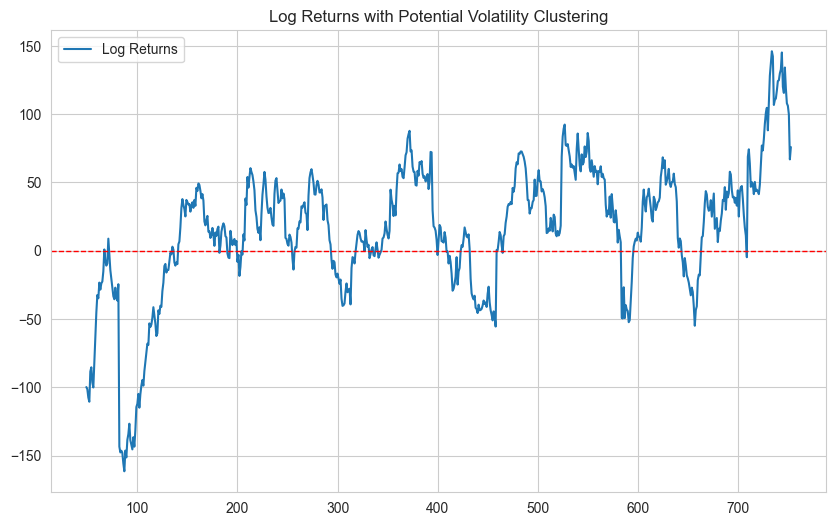

In [142]:
# Plot detrended
plt.figure(figsize=(10, 6))
plt.plot(detrended, label='Log Returns')
plt.title('Log Returns with Potential Volatility Clustering')
plt.axhline(0, linestyle='--', color='red', linewidth=1)
plt.legend()
plt.show()

#How do I manually understand volatility clustering

In [143]:
from statsmodels.stats.diagnostic import het_arch

# Perform ARCH test (p value is too high so volatility not present)
arch_test = het_arch(log_returns)
print("ARCH Test Statistic:", arch_test[0])
print("p-value:", arch_test[1])

ARCH Test Statistic: 0.8903187275346066
p-value: 0.9998992690292875


In [144]:
arch_test = het_arch(detrended)
print("ARCH Test Statistic:", arch_test[0])
print("p-value:", arch_test[1])
#p value is close to 0, so arch is appropraite

ARCH Test Statistic: 633.9762886952975
p-value: 9.188749885972511e-130


In [149]:
from arch import arch_model

# Fit a GARCH(1,1) model for log returns as a control as arch is inappropriate
garch_model_lr = arch_model(log_returns, vol='Garch', p=1, q=1)
garch_fit_lr = garch_model_lr.fit()
print(garch_fit_lr.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 33347754.75213183
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1175911279241.5283
Iteration:      3,   Func. Count:     32,   Neg. LLF: 677903420.6491103
Iteration:      4,   Func. Count:     40,   Neg. LLF: 13900953803.747082
Iteration:      5,   Func. Count:     52,   Neg. LLF: -1557.457569074401
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1557.457567143208
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 5
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1557.46
Distribution:                  Normal   AIC:                          -3106.92
Method:            Maximum Likelih

/Users/anilsaddatbijoy/.pyenv/versions/3.8.17/envs/stochasticEnv/lib/python3.8/site-packages/arch/univariate/base.py:310: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001038. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




In [148]:
# Fit a GARCH(1,1) model for detrended
garch_model_d = arch_model(detrended, vol='Garch', p=1, q=1)
garch_fit_d = garch_model_d.fit()
print(garch_fit_d.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19848.025199858526
Iteration:      2,   Func. Count:     12,   Neg. LLF: 3657.681811811413
Iteration:      3,   Func. Count:     18,   Neg. LLF: 3480.0084053132246
Iteration:      4,   Func. Count:     25,   Neg. LLF: 3372.852010297112
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3361.7694691608713
Iteration:      6,   Func. Count:     36,   Neg. LLF: 3360.930662382077
Iteration:      7,   Func. Count:     41,   Neg. LLF: 3359.2168969328973
Iteration:      8,   Func. Count:     46,   Neg. LLF: 3358.3446119236896
Iteration:      9,   Func. Count:     51,   Neg. LLF: 3358.31390715732
Iteration:     10,   Func. Count:     56,   Neg. LLF: 3358.3062028910044
Iteration:     11,   Func. Count:     61,   Neg. LLF: 3358.2694279949674
Iteration:     12,   Func. Count:     66,   Neg. LLF: 3358.2185635580354
Iteration:     13,   Func. Count:     71,   Neg. LLF: 3358.111720671312
Iteration:     14,   Func. Count:     76,   Neg. LLF: 335

In [151]:
forecast_lr = garch_fit_lr.forecast(horizon=5)
print(forecast_lr.variance[-1:])

          h.1       h.2       h.3       h.4       h.5
753  0.000737  0.000741  0.000745  0.000749  0.000753


/Users/anilsaddatbijoy/.pyenv/versions/3.8.17/envs/stochasticEnv/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning:


The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.




In [152]:
forecast_d = garch_fit_d.forecast(horizon=5)
print(forecast_d.variance[-1:])

             h.1          h.2          h.3          h.4          h.5
753  2046.048539  2102.164059  2158.233253  2214.256159  2270.232816


/Users/anilsaddatbijoy/.pyenv/versions/3.8.17/envs/stochasticEnv/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning:


The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.


